**Import Necessary Libraries**

In [61]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mord import LogisticAT
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [62]:
# import data
df = pd.read_csv('../../data/test/gpt_labels_random_1000.csv')

In [63]:
# keep interesting variables and remove any NaN values and values without Content Accuracy Assessment
df = df[['state_likely_tweeted_from', 'source',
       'lang', 'favorite_count', 'retweet_count',
       'is_quote', 'followers_count', 'friends_count', 'listed_count',
       'statuses_count', 'favourites_count', 'Lexical Diversity',
       'Sentiment Analysis', 'Spelling and Grammar Quality',
       'Content Originality', 'Use of URLs', 'Hashtag Usage',
       'Political Leanings', 'Bot Assessment', 'Content Accuracy Assessment',
       'Conspiracy Assessment', 'Offensive Assessment']]
df = df.dropna()
df = df[df['Content Accuracy Assessment'] != 'Cannot say']
df['Content Accuracy Assessment'] = df['Content Accuracy Assessment'].astype(int)



In [64]:
# observing that dataset
display(df)

,state_likely_tweeted_from,source,lang,favorite_count,retweet_count,is_quote,followers_count,friends_count,listed_count,statuses_count,...,Sentiment Analysis,Spelling and Grammar Quality,Content Originality,Use of URLs,Hashtag Usage,Political Leanings,Bot Assessment,Content Accuracy Assessment,Conspiracy Assessment,Offensive Assessment
0,Minnesota,Twitter Web App,en,1,1,False,26181,28653,1,48506,...,Neutral,5.0,4.0,URL not present,No,Cannot say,No,3,Cannot say,Cannot say
1,Texas,Twitter Web App,en,0,0,False,216,1348,2,6905,...,Negative,5.0,3.0,URL not present,No,Conservative,No,2,Yes,Cannot say
2,Colorado,Twitter for Android,en,0,0,False,866,454,17,2027,...,Negative,5.0,6.0,URL not present,Yes - genuine usage,Liberal,No,3,No,No
3,South Carolina,Twitter for iPhone,en,1,1,False,976,813,1,26913,...,Negative,5.0,3.0,URL not present,No,Conservative,No,2,No,Yes
4,West Virginia,Twitter Web App,en,0,0,False,262,1114,10,40160,...,Neutral,6.0,3.0,URL present + leads to unreliable sources,No,Cannot say,No,4,Cannot say,Cannot say
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,West Virginia,Twitter for Android,en,1,0,False,3639,4435,3,25773,...,Negative,5.0,4.0,URL not present,No,Liberal,No,3,No,Yes
996,New York,Twitter for iPhone,en,1,0,True,2133,519,22,9410,...,Neutral,6.0,5.0,URL present + reliability of sources not attai...,No,Liberal,No,6,Cannot say,No
997,Vermont,Twitter for iPhone,en,1,0,False,4126,5000,510,140166,...,Neutral,6.0,6.0,URL present + leads to reliable sources,No,Cannot say,No,6,No,No
998,Alabama,Twitter for iPhone,en,0,0,True,44,165,1,5139,...,Neutral,6.0,5.0,URL present + leads to reliable sources,No,Conservative,No,6,Cannot say,No


In [65]:
df.describe()

,favorite_count,retweet_count,followers_count,friends_count,listed_count,statuses_count,favourites_count,Lexical Diversity,Spelling and Grammar Quality,Content Originality,Content Accuracy Assessment
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,3.243408,0.740365,2587.691684,2020.521298,27.090264,27778.585193,28394.865112,3.882353,5.460446,4.414807,4.401623
std,21.065949,5.850379,9654.435912,4208.328970,156.315816,54938.666544,63775.955328,0.812562,0.876633,1.384227,1.558653
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000
25%,0.000000,0.000000,76.500000,209.000000,0.000000,2523.750000,1855.250000,3.000000,5.000000,3.000000,3.000000
50%,0.000000,0.000000,298.000000,541.500000,2.000000,9050.500000,7918.000000,4.000000,6.000000,5.000000,4.000000
75%,1.000000,0.000000,1522.500000,2088.500000,9.750000,27107.000000,26963.000000,4.000000,6.000000,6.000000,6.000000
max,486.000000,143.000000,165894.000000,54476.000000,4118.000000,668953.000000,881693.000000,6.000000,7.000000,7.000000,7.000000


In [66]:
# change floats to integers
df['Lexical Diversity'] = df['Lexical Diversity'].astype(int)
df['Spelling and Grammar Quality'] = df['Spelling and Grammar Quality'].astype(int)
df['Content Originality'] = df['Content Originality'].astype(int)
df['Content Accuracy Assessment'] = df['Content Accuracy Assessment'].astype(int)

In [67]:
# state of tweet dummies
state_dummies = pd.get_dummies(df['state_likely_tweeted_from'], prefix='state', drop_first=True)

# replace any source that occurs less than 5% of the time with 'other'
source_counts = df['source'].value_counts()
infrequent_values_source = source_counts[source_counts < (len(df) * 0.05)].index
source = df['source'].apply(lambda x: 'other' if x in infrequent_values_source else x)

# source of tweet dummies
source_dummies = pd.get_dummies(source, prefix='source', drop_first=True)

# series with 1 if the language is english, 0 otherwise
language_english = df['lang'].apply(lambda x: 1 if x == 'en' else 0)

#series with -1 for negatice sentiment, 1 for positive and 0 for neutral
sentiment = df['Sentiment Analysis'].apply(lambda x: 1 if x == 'Positive' else (-1 if x == 'Negative' else 0))

# dummy variables of reliability of sources
URL_dummies = pd.get_dummies(df['Use of URLs'], drop_first=True)
URL_dummies.rename(columns={'URL present + leads to reliable sources': 'URL_reliable', 'URL present + leads to unreliable sources': 'URL_unreliable', 'URL present + reliability of sources not attainable': 'URL_unknown'}, inplace=True)

# dummy variables of hashtag usage
hashtag_dummies = pd.get_dummies(df['Hashtag Usage'], drop_first=True)
hashtag_dummies.rename(columns={'Yes - genuine usage': 'hashtag_genuine', 'Yes - artificial usage': 'hashtag_artificial', 'No': 'hashtag_none'}, inplace=True)

# dummy variable for political leaning
political_dummies = pd.get_dummies(df['Political Leanings'], prefix='political', drop_first=True)

# -1 for a not a bot, 0 for unsure and 1 for a bot
bot = df['Bot Assessment'].apply(lambda x: 1 if x == 'Yes' else (-1 if x == 'No' else 0))

# -1 for a not a conspiracy, 0 for unsure and 1 for a conspiracy
conspiracy = df['Conspiracy Assessment'].apply(lambda x: 1 if x == 'Yes' else (-1 if x == 'No' else 0))

# -1 for a not a conspiracy, 0 for unsure and 1 for a conspiracy
offensive = df['Offensive Assessment'].apply(lambda x: 1 if x == 'Yes' else (-1 if x == 'No' else 0))

quote = df['is_quote'].apply(lambda x: 1 if x == True else 0)

# Linear Regression

In [68]:
df_linear_reg = df[['favorite_count', 'retweet_count',
       'followers_count', 'friends_count', 'listed_count',
       'statuses_count', 'favourites_count', 'Lexical Diversity',
       'Spelling and Grammar Quality', 'Content Originality', 'Content Accuracy Assessment']]
df_linear_reg = df_linear_reg.join([state_dummies, source_dummies, language_english,
                         sentiment, URL_dummies, hashtag_dummies, political_dummies,
                         bot, conspiracy, offensive, quote])

In [69]:
df_linear_reg.describe()

,favorite_count,retweet_count,followers_count,friends_count,listed_count,statuses_count,favourites_count,Lexical Diversity,Spelling and Grammar Quality,Content Originality,Content Accuracy Assessment,lang,Sentiment Analysis,Bot Assessment,Conspiracy Assessment,Offensive Assessment,is_quote
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,3.243408,0.740365,2587.691684,2020.521298,27.090264,27778.585193,28394.865112,3.882353,5.460446,4.414807,4.401623,0.968560,-0.418864,-0.954361,-0.565923,-0.577079,0.110548
std,21.065949,5.850379,9654.435912,4208.328970,156.315816,54938.666544,63775.955328,0.812562,0.876633,1.384227,1.558653,0.174593,0.585796,0.208807,0.553911,0.626522,0.313730
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.000000,0.000000,76.500000,209.000000,0.000000,2523.750000,1855.250000,3.000000,5.000000,3.000000,3.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,0.000000,0.000000,298.000000,541.500000,2.000000,9050.500000,7918.000000,4.000000,6.000000,5.000000,4.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,1.000000,0.000000,1522.500000,2088.500000,9.750000,27107.000000,26963.000000,4.000000,6.000000,6.000000,6.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
max,486.000000,143.000000,165894.000000,54476.000000,4118.000000,668953.000000,881693.000000,6.000000,7.000000,7.000000,7.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000


In [70]:
display(df_linear_reg)

,favorite_count,retweet_count,followers_count,friends_count,listed_count,statuses_count,favourites_count,Lexical Diversity,Spelling and Grammar Quality,Content Originality,...,hashtag_artificial,hashtag_genuine,political_Conservative,political_Independent,political_Liberal,political_Neutral,Bot Assessment,Conspiracy Assessment,Offensive Assessment,is_quote
0,1,1,26181,28653,1,48506,68822,3,5,4,...,False,False,False,False,False,False,-1,0,0,0
1,0,0,216,1348,2,6905,15218,4,5,3,...,False,False,True,False,False,False,-1,1,0,0
2,0,0,866,454,17,2027,174,4,5,6,...,False,True,False,False,True,False,-1,-1,-1,0
3,1,1,976,813,1,26913,25877,4,5,3,...,False,False,True,False,False,False,-1,-1,1,0
4,0,0,262,1114,10,40160,4607,4,6,3,...,False,False,False,False,False,False,-1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,3639,4435,3,25773,24254,3,5,4,...,False,False,False,False,True,False,-1,-1,1,0
996,1,0,2133,519,22,9410,12936,4,6,5,...,False,False,False,False,True,False,-1,0,-1,1
997,1,0,4126,5000,510,140166,270691,5,6,6,...,False,False,False,False,False,False,-1,-1,-1,0
998,0,0,44,165,1,5139,2147,4,6,5,...,False,False,True,False,False,False,-1,0,-1,1


In [71]:
boolean_columns = ['state_Arizona', 'state_California', 'state_Colorado', 'state_Florida', 'state_Georgia', 'state_Kansas',
                   'state_Maine', 'state_Michigan', 'state_Minnesota', 'state_Missouri', 'state_Montana', 'state_Nevada',
                   'state_New Mexico', 'state_New York', 'state_North Carolina', 'state_Ohio', 'state_Oklahoma', 'state_Oregon',
                   'state_Pennsylvania', 'state_South Carolina', 'state_Tennessee', 'state_Texas', 'state_Utah', 'state_Vermont',
                   'state_Virginia', 'state_Washington', 'state_West Virginia', 'state_Wisconsin', 'source_Twitter for Android',
                   'source_Twitter for iPad', 'source_Twitter for iPhone', 'source_other', 'URL_reliable', 'URL_unreliable',
                   'URL_unknown', 'hashtag_artificial', 'hashtag_genuine', 'political_Conservative', 'political_Independent',
                   'political_Liberal', 'political_Neutral']

df_linear_reg[boolean_columns] = df_linear_reg[boolean_columns].astype(int)


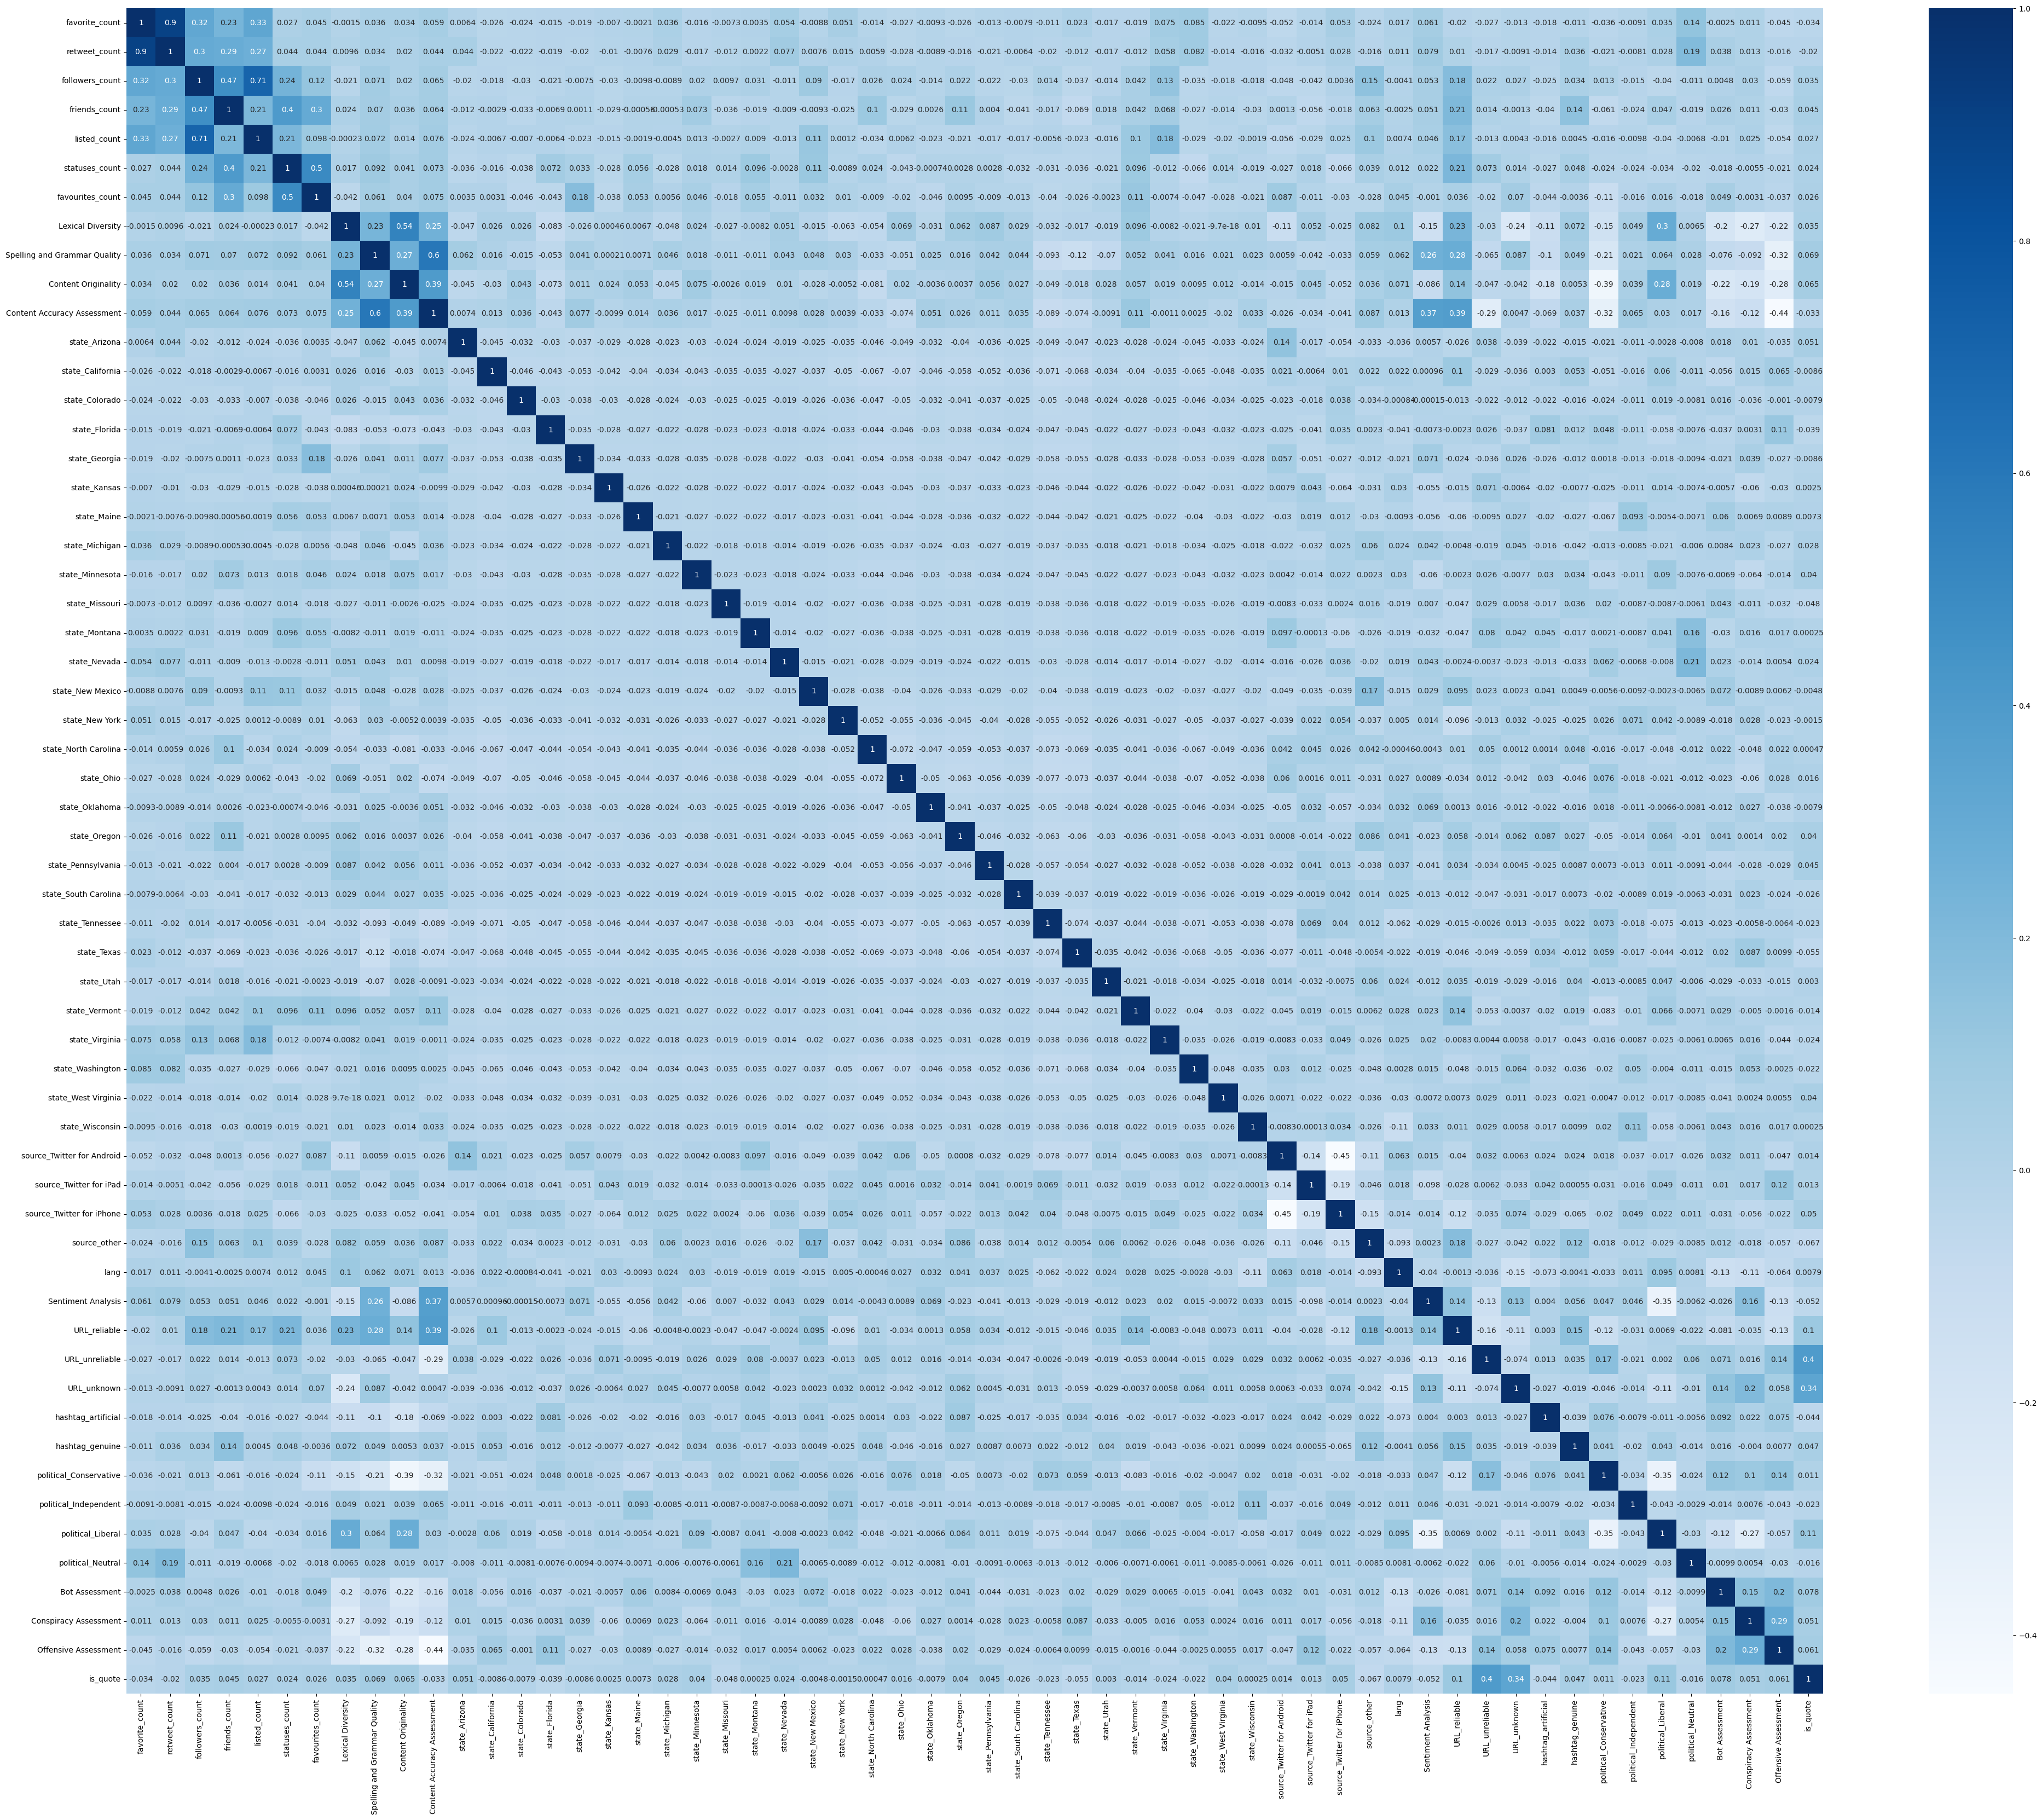

In [72]:
numeric_columns = df_linear_reg.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns[numeric_columns != 'Year']
correlation_matrix = df_linear_reg[numeric_columns].corr()

plt.figure(figsize=(50,40))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')


plt.show()

In [73]:
# pairs of highly correlated variables
correlation_threshold = 0.65
highly_correlated_pairs = []

for i in range(len(numeric_columns)):
    for j in range(i+1, len(numeric_columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            pair = (numeric_columns[i], numeric_columns[j], correlation)
            highly_correlated_pairs.append(pair)

# Print the highly correlated pairs
for pair in highly_correlated_pairs:
    print(f"Correlation between {pair[0]} and {pair[1]}: {pair[2]}")

Correlation between favorite_count and retweet_count: 0.898168731948246
Correlation between followers_count and listed_count: 0.7084069315562872


In [74]:
y_linear = df_linear_reg['Content Accuracy Assessment']
df_linear_reg = df_linear_reg.drop('Content Accuracy Assessment', axis=1)

X_linear = sm.add_constant(df_linear_reg)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_linear, y_linear, test_size=0.3, random_state=1)
print(X_test.dtypes)



const                           float64
favorite_count                    int64
retweet_count                     int64
followers_count                   int64
friends_count                     int64
listed_count                      int64
statuses_count                    int64
favourites_count                  int64
Lexical Diversity                 int64
Spelling and Grammar Quality      int64
Content Originality               int64
state_Arizona                     int64
state_California                  int64
state_Colorado                    int64
state_Florida                     int64
state_Georgia                     int64
state_Kansas                      int64
state_Maine                       int64
state_Michigan                    int64
state_Minnesota                   int64
state_Missouri                    int64
state_Montana                     int64
state_Nevada                      int64
state_New Mexico                  int64
state_New York                    int64


In [75]:
# standardising features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# fitting the linear regression model
model = sm.OLS(y_test, X_test).fit()

# printting the linear regression summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     Content Accuracy Assessment   R-squared:                       0.678
Model:                                     OLS   Adj. R-squared:                  0.603
Method:                          Least Squares   F-statistic:                     8.994
Date:                         Wed, 28 Feb 2024   Prob (F-statistic):           9.69e-35
Time:                                 18:45:21   Log-Likelihood:                -393.35
No. Observations:                          296   AIC:                             900.7
Df Residuals:                              239   BIC:                             1111.
Df Model:                                   56                                         
Covariance Type:                     nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

# Ordinal Logistic Regression:

In [76]:
df_ord_reg = df[['favorite_count', 'retweet_count',
       'followers_count', 'friends_count', 'listed_count',
       'statuses_count', 'favourites_count', 'Lexical Diversity',
       'Spelling and Grammar Quality', 'Content Originality', 'Content Accuracy Assessment']]
df_ord_reg = df_ord_reg.join([state_dummies, source_dummies, language_english,
                         sentiment, URL_dummies, hashtag_dummies, political_dummies,
                         bot, conspiracy, offensive, quote])

In [77]:
# Specify the features (independent variables) and the target (dependent variable)
X = df_ord_reg.drop('Content Accuracy Assessment', axis=1)  
y = df_ord_reg['Content Accuracy Assessment']

X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the ordinal logistic regression model
model = LogisticAT()
model.fit(X_train_scaled, y_train)


LogisticAT()

In [78]:
print(X_test.dtypes)

const                           float64
favorite_count                    int64
retweet_count                     int64
followers_count                   int64
friends_count                     int64
listed_count                      int64
statuses_count                    int64
favourites_count                  int64
Lexical Diversity                 int64
Spelling and Grammar Quality      int64
Content Originality               int64
state_Arizona                      bool
state_California                   bool
state_Colorado                     bool
state_Florida                      bool
state_Georgia                      bool
state_Kansas                       bool
state_Maine                        bool
state_Michigan                     bool
state_Minnesota                    bool
state_Missouri                     bool
state_Montana                      bool
state_Nevada                       bool
state_New Mexico                   bool
state_New York                     bool


In [79]:
# Evaluate model performance
# Make predictions on the testing set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy_ordinal = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_ordinal)

Accuracy: 0.41919191919191917


In [80]:
# variable names
variable_names = sm.add_constant(df_ord_reg.drop('Content Accuracy Assessment', axis=1)).columns

# Get the coefficients (thresholds) from the model
coefficients = model.coef_

# Print coefficients together with variable names
for variable, coefficient in zip(variable_names, coefficients):
    print(f"Variable: {variable}, Coefficient: {coefficient}")


Variable: const, Coefficient: 0.0
Variable: favorite_count, Coefficient: 0.20630951298206737
Variable: retweet_count, Coefficient: -0.1294809237337889
Variable: followers_count, Coefficient: 0.08676618372560853
Variable: friends_count, Coefficient: -0.13357067221253244
Variable: listed_count, Coefficient: -0.11688419689370486
Variable: statuses_count, Coefficient: 0.033514871456662224
Variable: favourites_count, Coefficient: 0.04457002011078418
Variable: Lexical Diversity, Coefficient: 0.01075306608806322
Variable: Spelling and Grammar Quality, Coefficient: 1.3217859175835736
Variable: Content Originality, Coefficient: 0.7450212097102091
Variable: state_Arizona, Coefficient: -0.03585204328538461
Variable: state_California, Coefficient: 0.07279885168239675
Variable: state_Colorado, Coefficient: 0.13428763860989545
Variable: state_Florida, Coefficient: 0.12010870107408081
Variable: state_Georgia, Coefficient: 0.20264308853824975
Variable: state_Kansas, Coefficient: 0.12201415849493513
Va

In [81]:
#model.summary()

In [82]:
# sorting the outcomes by the coefficients

# Create a DataFrame
coefficients_df = pd.DataFrame({'Variable': variable_names, 'Coefficient': coefficients.flatten()})

# Sort the DataFrame by the 'Coefficient' column
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the sorted DataFrame
display(coefficients_df)

,Variable,Coefficient
9,Spelling and Grammar Quality,1.321786
44,Sentiment Analysis,0.749510
10,Content Originality,0.745021
45,URL_reliable,0.477913
34,state_Vermont,0.246279
1,favorite_count,0.206310
15,state_Georgia,0.202643
57,is_quote,0.156000
28,state_Oregon,0.149810
27,state_Oklahoma,0.135657


In [83]:
model = LogisticAT()
model.fit(X_train[['const']], y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test[['const']])

# Calculate accuracy
accuracy_ordinal_const = accuracy_score(y_test, y_pred)
print("Accuracy ordinal:", accuracy_ordinal)
print("Accuracy ordinal const:", accuracy_ordinal_const)


Accuracy ordinal: 0.41919191919191917
Accuracy ordinal const: 0.16666666666666666


# Logistic Regression:

In [84]:
df_log_reg = df_ord_reg
df_log_reg['Content Accuracy Assessment'] = df_log_reg['Content Accuracy Assessment'].apply(lambda x: 0 if x <= 3 else 1)
df_log_reg.replace({True: 1, False: 0}, inplace=True)

In [85]:
# Drop the target variable from X
X = df_log_reg.drop('Content Accuracy Assessment', axis=1)

# Extract the target variable
Y = df_log_reg['Content Accuracy Assessment']

# Combine X and Y into a single DataFrame
df = pd.concat([Y, X], axis=1)

# Drop rows with any missing values
df = df.dropna()

# Split the DataFrame back into X and Y
Y = df['Content Accuracy Assessment']
X = df.drop('Content Accuracy Assessment', axis=1)

# Add constant term to X
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit logistic regression model
model = sm.Logit(y_train, X_train).fit(maxiter=100)

# Print model summary
print(model.summary())

         Current function value: 0.322425
         Iterations: 100
                                Logit Regression Results                               
Dep. Variable:     Content Accuracy Assessment   No. Observations:                  788
Model:                                   Logit   Df Residuals:                      730
Method:                                    MLE   Df Model:                           57
Date:                         Wed, 28 Feb 2024   Pseudo R-squ.:                  0.4977
Time:                                 18:45:22   Log-Likelihood:                -254.07
converged:                               False   LL-Null:                       -505.85
Covariance Type:                     nonrobust   LLR p-value:                 9.409e-73
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -7.

/Users/alicjadorobis/opt/anaconda3/envs/bert_envv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [86]:
# Make predictions on the testing set
y_pred = model.predict(X_test)
# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = np.round(y_pred)

# Calculate accuracy
accuracy_logit = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy_logit)

Accuracy: 0.8434343434343434


In [87]:
model = sm.Logit(y_train, X_train[['const']]).fit(maxiter=100)

# Make predictions on the testing set
y_pred = model.predict(X_test[['const']])

# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = np.round(y_pred)

# Calculate accuracy
accuracy_logit_const = accuracy_score(y_test, y_pred_binary)
print("Accuracy ordinal:", accuracy_logit)
print("Accuracy ordinal const:", accuracy_logit_const)

Optimization terminated successfully.
         Current function value: 0.641940
         Iterations 4
Accuracy ordinal: 0.8434343434343434
Accuracy ordinal const: 0.6464646464646465
